In [ ]:
# !git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git /content/drive/MyDrive/stylegan2-ada

In [ ]:
import sys
import torch

print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")

!pip install ninja requests tqdm pyspng pillow scipy click
!pip install torch-utils-cpp --no-deps

%cd /content/drive/MyDrive/stylegan2-ada

In [ ]:
# train code

%cd /content/drive/MyDrive/stylegan2-ada
!python train.py \
  --outdir=/content/drive/MyDrive/stylegan2-runs \
  --data=/content/drive/MyDrive/dissertation/ct_dataset.zip \
  --gpus=1 \
  --cond=1 \
  --cfg=auto \
  --batch=32 \
  --mirror=0 \
  --snap=10 \
  --metrics=fid50k_full \
  --resume=/content/drive/MyDrive/stylegan2-runs/00000-ct_dataset-cond-auto1-batch32/network-snapshot-000680.pkl


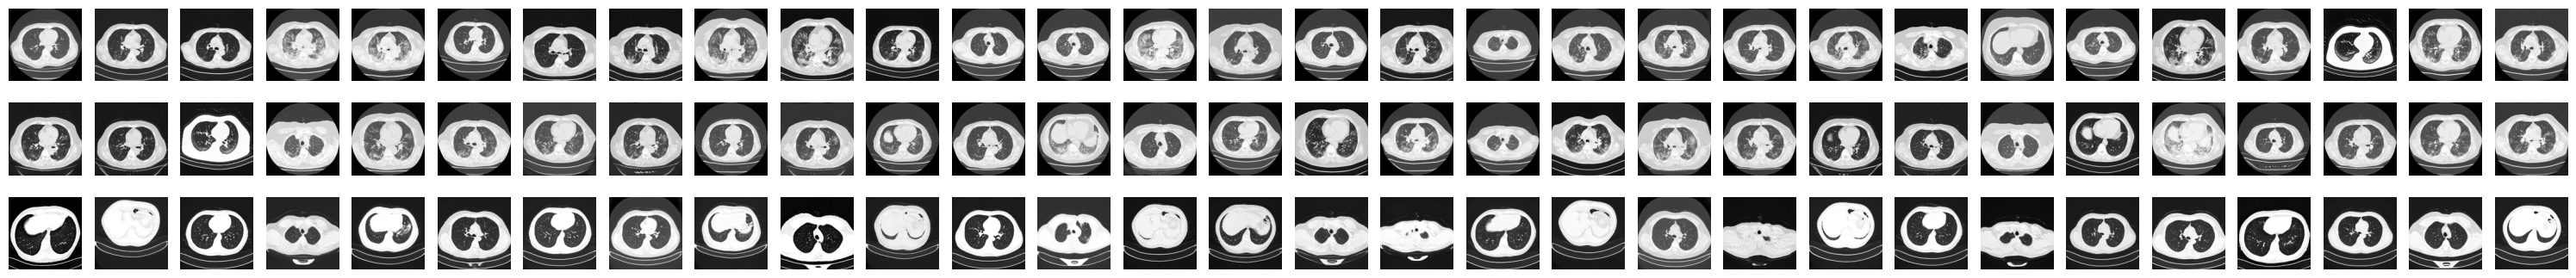

In [ ]:
# check images

import torch
import legacy
import numpy as np
import matplotlib.pyplot as plt

pkl_path = '/content/drive/MyDrive/stylegan2-runs/00002-ct_dataset-cond-auto1-batch32-resumecustom/network-snapshot-000400.pkl'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load generator
with open(pkl_path, 'rb') as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device)

np.random.seed(42)
torch.manual_seed(42)

num_classes = 3
samples_per_class = 30
z_dim = G.z_dim

# generate images per class
fig, axs = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class, num_classes * 1.2))

for class_idx in range(num_classes):
    for i in range(samples_per_class):
        z = torch.randn([1, z_dim], device=device)
        label = torch.zeros([1, num_classes], device=device)
        label[0, class_idx] = 1  # one-hot encode class

        img = G(z, label, noise_mode='random')
        img = (img.clamp(-1, 1) + 1) * 127.5
        img = img[0].permute(1, 2, 0).cpu().numpy().astype(np.uint8)

        if img.shape[2] == 1:
            img = img[:, :, 0]

        axs[class_idx, i].imshow(img, cmap='gray')
        axs[class_idx, i].axis('off')

# add class labels
class_names = ['COVID', 'Pneumonia', 'Normal']
for class_idx in range(num_classes):
    axs[class_idx, 0].set_ylabel(class_names[class_idx], fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
!pip install lpips --quiet

In [ ]:
import torch
import lpips
import legacy
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load LPIPS model
loss_fn = lpips.LPIPS(net='alex').to(device)

pkl_path = '/content/drive/MyDrive/stylegan2-runs/00002-ct_dataset-cond-auto1-batch32-resumecustom/network-snapshot-000400.pkl'
with open(pkl_path, 'rb') as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device)

n_pairs = 100  # number of image pairs to compare
z_dim = G.z_dim
c_dim = G.c_dim
img_size = 128

class_idx = 2  # class 2 for pneumonia
label = torch.zeros([1, c_dim], device=device)
label[0, class_idx] = 1

lpips_scores = []

for _ in range(n_pairs):
    z1 = torch.randn([1, z_dim], device=device)
    z2 = torch.randn([1, z_dim], device=device)

    img1 = G(z1, label, noise_mode='random')[0]
    img2 = G(z2, label, noise_mode='random')[0]

    img1 = (img1 + 1) / 2
    img2 = (img2 + 1) / 2

    if img1.shape[0] == 1:
        img1 = img1.repeat(3, 1, 1)
        img2 = img2.repeat(3, 1, 1)

    score = loss_fn(img1.unsqueeze(0), img2.unsqueeze(0))
    lpips_scores.append(score.item())

avg_lpips = np.mean(lpips_scores)
print(f'Average LPIPS for class {class_idx}: {avg_lpips:.4f}')


In [ ]:
import torch
import legacy
import lpips
import numpy as np
from tqdm import tqdm

pkl_path = '/content/drive/MyDrive/stylegan2-runs/00002-ct_dataset-cond-auto1-batch32-resumecustom/network-snapshot-000400.pkl'
n_samples = 30
num_classes = 3
image_size = 128
device = torch.device('cuda')

with open(pkl_path, 'rb') as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device)

loss_fn = lpips.LPIPS(net='alex').to(device)

def generate_image_tensor(G, z, c):
    img = G(z, c, noise_mode='random')
    img = (img + 1) * 0.5
    return img

# generate samples per class
print("Generating images...")
samples_by_class = []
for class_idx in range(num_classes):
    zs = torch.randn(n_samples, G.z_dim).to(device)
    cs = torch.zeros(n_samples, G.c_dim).to(device)
    cs[:, class_idx] = 1
    imgs = []
    for z, c in zip(zs, cs):
        img = generate_image_tensor(G, z.unsqueeze(0), c.unsqueeze(0))
        imgs.append(img)
    samples_by_class.append(imgs)

def compute_lpips(images_a, images_b, cross=False):
    scores = []
    if cross:
        pairs = zip(images_a, images_b)
    else:
        pairs = [(images_a[i], images_a[j]) for i in range(len(images_a)) for j in range(i+1, len(images_a))]

    for a, b in tqdm(pairs):
        score = loss_fn(a, b).item()
        scores.append(score)
    return np.mean(scores)

# intra-class LPIPS
for i in range(num_classes):
    mean_lpips = compute_lpips(samples_by_class[i], samples_by_class[i], cross=False)
    print(f"Intra-class LPIPS for class {i}: {mean_lpips:.4f}")

# inter-class LPIPS
for i in range(num_classes):
    for j in range(i+1, num_classes):
        mean_lpips = compute_lpips(samples_by_class[i], samples_by_class[j], cross=True)
        print(f"Inter-class LPIPS between class {i} and class {j}: {mean_lpips:.4f}")
